MicroGrad

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def f(x):
    return 1 / (1 + x**2)

In [3]:
f(5.3)

0.034376074252320386

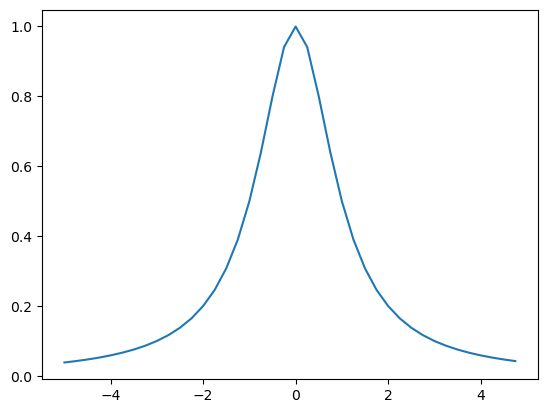

In [4]:
rx = np.arange(-5, 5, 0.25)
ry = f(rx)
plt.plot(rx, ry)

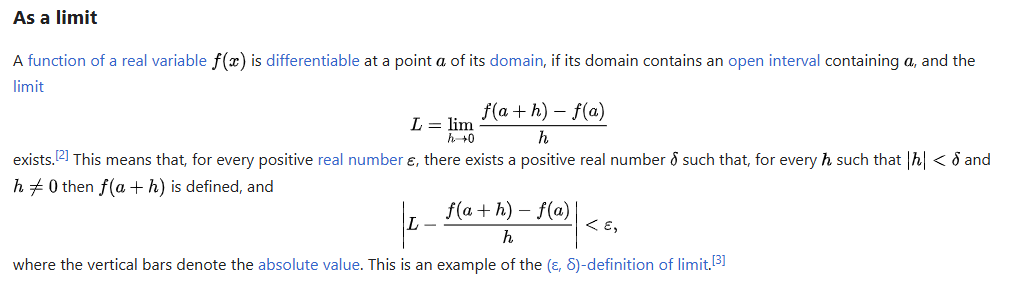

In [5]:
h = 0.0000000001
x = 0.3
f(x + h)
# f(x)

(f(x + h) - f(x)) / h

-0.5050082574342696

In [6]:
a = 5.0
b = -5.0
c = 10.0

d = a*b + c
print(d)

-15.0


In [7]:
h = 0.00000001

a = 5.0
b = -5.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
# print(d1, d2)
print('slope = ', (d2 - d1) / h)


slope =  -5.000000058430487


In [52]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data = {self.data})'
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, (self, other), _op='+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, (self, other), _op='*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self * other
    
    def __sub__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data - other.data, (self, other), _op='-')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad -= 1.0 * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(x * 2.0) - 1.0) / (math.exp(x * 2.0) + 1.0)
        # print('x : ', x, '--> tanh : ', t)
        out = Value(t, (self,), _op='tanh')
        # print('tanh', out.data)
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), _op=f'**{other}')
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __truediv__(self, other):
        return self * other**-1
    
    def backward(self) :

        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
          self.grad += out.data * out.grad 
        out._backward = _backward

        return out    

In [ ]:
# %pip install graphviz

In [10]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

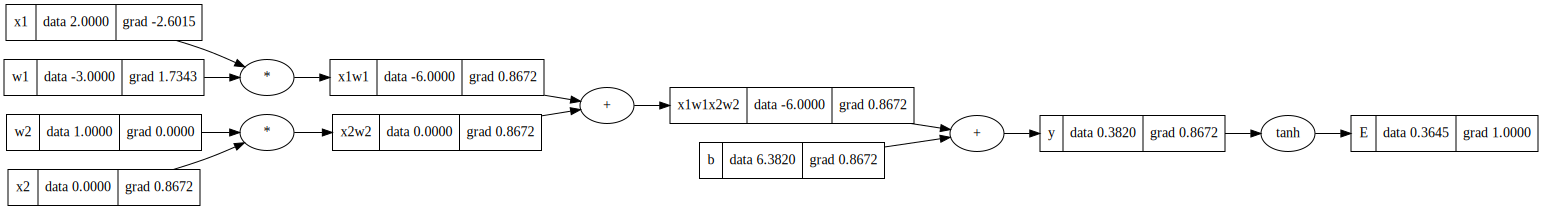

In [11]:
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'
b = Value(6.382011, label='b')
y = x1w1x2w2 + b; y.label = 'y'
E = y.tanh()
E.label = 'E'
E.backward()

draw_dot(E)

In [13]:
%pip install torch torchvision torchaudio


   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/212.5 MB 1.1 MB/s eta 0:03:15
   ---------------------------------------- 0.2/212.5 MB 2.3 MB/s eta 0:01:32
   ---------------------------------------- 0.5/212.5 MB 3.1 MB/s eta 0:01:08
   ---------------------------------------- 0.7/212.5 MB 3.6 MB/s eta 0:00:59
   ---------------------------------------- 0.9/212.5 MB 4.0 MB/s eta 0:00:54
   ---------------------------------------- 1.2/212.5 MB 4.3 MB/s eta 0:00:50
   ---------------------------------------- 1.7/212.5 MB 5.1 MB/s eta 0:00:42
   ---------------------------------------- 2.2/212.5 MB 6.0 MB/s eta 0:00:36
    --------------------------------------- 2.8/212.5 MB 6.5 MB/s eta 0:00:33
    --------------------------------------- 3.3/212.5 MB 7.0 MB/s eta 0:00:30
    --------------------------------------- 3.7/212.5 MB 7.4 MB/s eta 0:00:29
    --------------------------------------- 3.7/212.5 MB 7.4 MB/s eta 

In [46]:
import torch

In [18]:
x1 = torch.Tensor([2.0]).double();      x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();      x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();     w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();      w2.requires_grad = True
b = torch.Tensor([6.382011]).double();  b.requires_grad = True
# b = Value(6.382011, label='b')

y = x1*w1 + x2*w2 + b

E = torch.tanh(y)
E.backward()
print(E.data.item())

print('x1' , x1.grad.item())
print('w1' , w1.grad.item())
print('w2' , w2.grad.item())
print('x2' , x2.grad.item())

# draw_dot(E)

0.3644525768966693
x1 -2.601522957580132
w1 1.7343486383867548
w2 0.0
x2 0.8671743191933774


In [53]:
class Neuron:
    def __init__(self, n_inputs):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((w_i * x_i for w_i, x_i in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:
    def __init__(self, n_inputs, n_neurons):
        self.neurons = [Neuron(n_inputs=n_inputs) for _ in range(n_neurons)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:
    def __init__(self, n_inputs, n_neurons):
        sz = [n_inputs] + n_neurons
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_neurons))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

    

In [514]:
x = [3.0, 5.0, 1.0]

n = MLP(3, [4, 4, 1])
n(x)
# g(y)

Value(data = 0.7903638756091473)

In [515]:
xs = [[2.0, 4.7, 3.9],
      [1.0, 2.0, 3.0],
      [3.0, 5.0, 1.0],
      [4.0, 2.0, 6.0],
      [5.0, 1.0, 2.0]]

ys = [0.0, 1.0, 0.0, 1.0, 0.0]

for k in range(200):

      ypred = [n(x) for x in xs]

      loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

      for p in n.parameters():
          p.grad = 0.0

      loss.backward()

      for p in n.parameters():
          p.data += -0.01 * p.grad

      print(loss.data)


1.9453152063032597
1.7654907048206403
1.5420279322828785
1.2766830731458076
0.9904816615104068
0.727449917935116
0.5295939354725241
0.402044578561104
0.3222810870902036
0.27009603632191836
0.23445065449395736
0.2092910925382445
0.1909404126293563
0.1770674084547714
0.16617807829949044
0.1573111822546848
0.14984568413206736
0.143377867511122
0.13764292344249537
0.132464984956362
0.1277253215472883
0.12334209702462388
0.11925747505287554
0.11542938803457686
0.1118262650183351
0.1084236385718639
0.10520194675152526
0.10214509714261336
0.09923951855556114
0.09647352621597678
0.09383688967469633
0.09132053278168233
0.08891632049514037
0.08661690344562244
0.08441560145565863
0.08230631378024085
0.08028344804049038
0.07834186253046499
0.07647681832862172
0.07468393878552525
0.07295917470694616
0.07129877404604398
0.06969925524898872
0.06815738362228949
0.06667015024397052
0.06523475304833017
0.0638485797906929
0.06250919265439055
0.06121431430375224
0.059961815218528676
0.058749702169803096
0

In [516]:
ypred

[Value(data = 0.016502606982609164),
 Value(data = 0.9118251784412746),
 Value(data = -0.008981115116660172),
 Value(data = 0.9514081060346432),
 Value(data = 0.003673423917370648)]

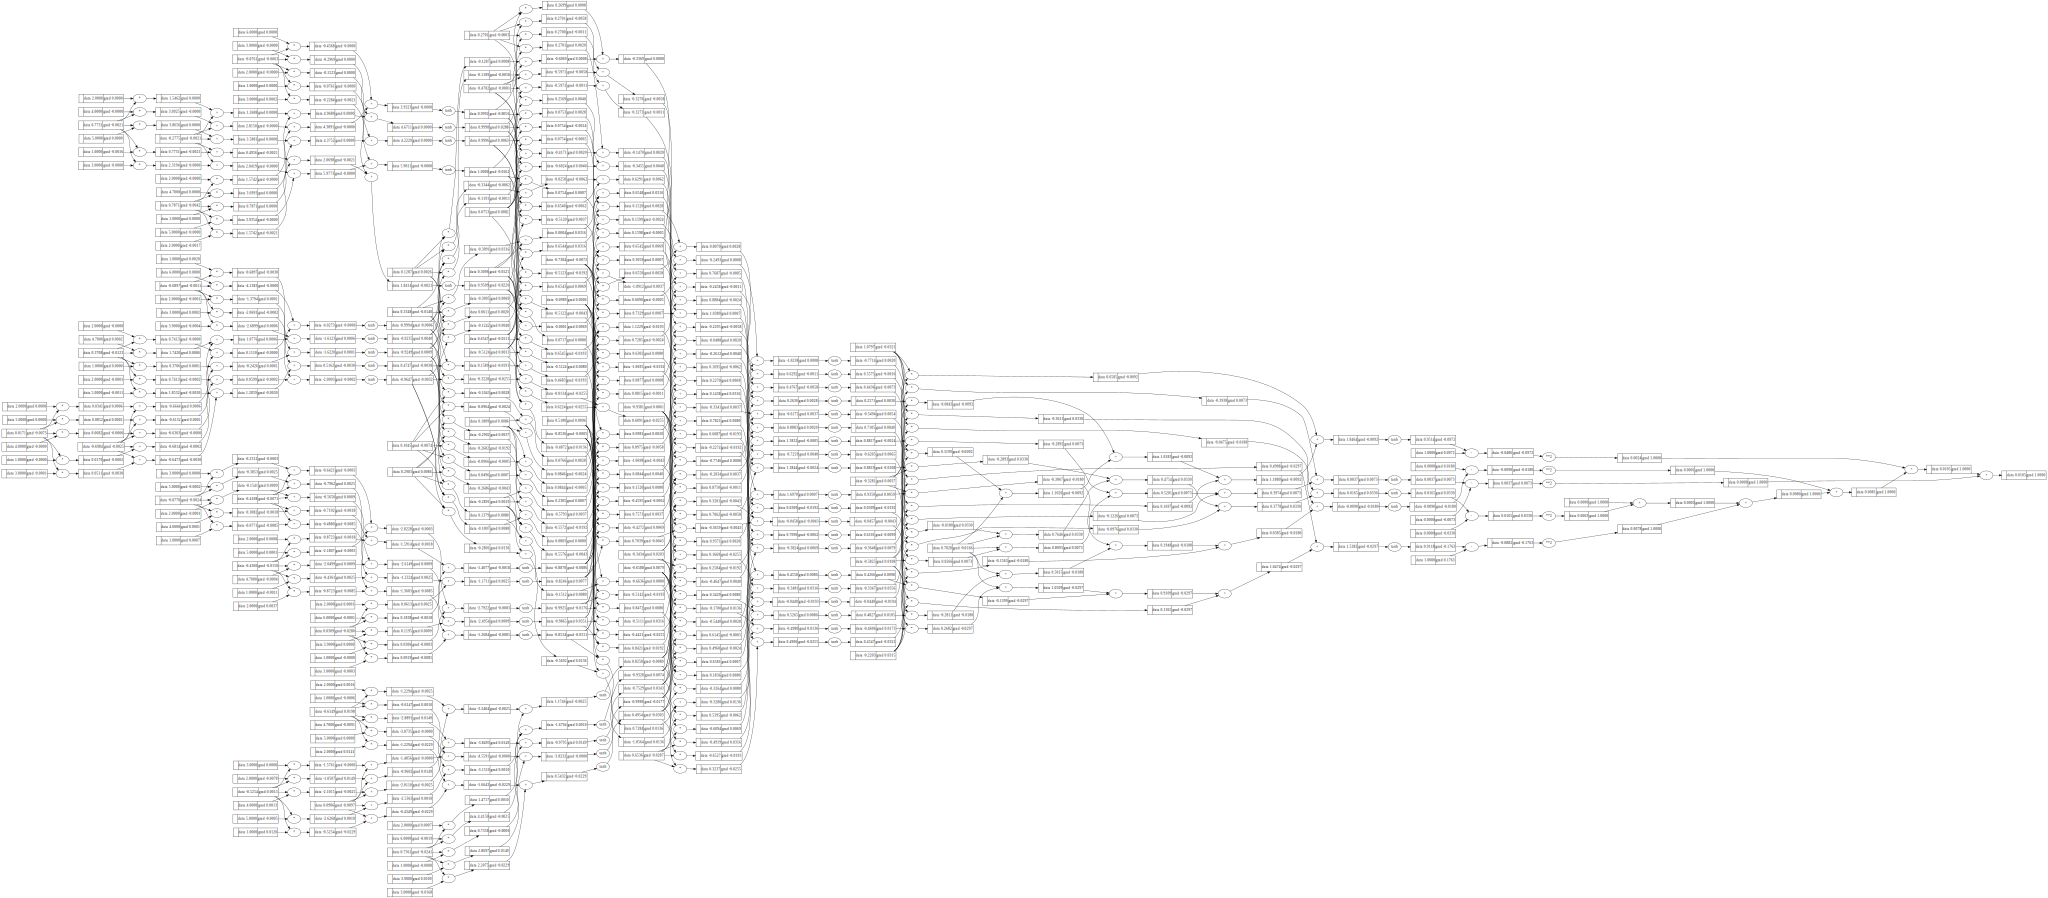

In [517]:
draw_dot(loss)